In [1]:
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary

In [2]:
df_test = pd.read_csv('dataset/rossmann/test.csv')

- Para verificar que columnas tiene originalmente tests. Por ejemplo, como es de esperar, la columna customers no es dato y podría intentar estimarse tambien
- Es bastante discutible usar el clima y temperatura (Se puede usar el forecast si es en el futuro
- En un caso real no parece sensato usar google trend

In [3]:
df_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [4]:
df = pd.read_feather('normalized_data.fth')

In [5]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

In [6]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [7]:
DataFrameSummary(df[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,2,25,26,4,3,...,8,12,52,22,6,6,3,3,8,8
types,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,...,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


In [8]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [9]:
uniques

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,2,25,26,4,3,...,8,12,52,22,6,6,3,3,8,8


# Asignación de dimensión de embeddings

In [10]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 4, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

## Ejemplo con DayOfWeek, store y CompetitionDistance

In [50]:
uniques['DayOfWeek'][0]

7

In [121]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Embedding, Input, Flatten, merge, Dense

In [122]:
day_of_week_input = Input(shape=(1,), name="day_of_week_input")
store_input = Input(shape=(1,), name="store_input")
# Por ser continua competition_distance no necesita embeddings
competition_distance_input = Input(shape=(1,), name="competition_distance_input")

day_of_week_Embedd_out = Embedding(uniques['DayOfWeek'][0], cat_var_dict['DayOfWeek'], name="day_of_week_Embedd")(day_of_week_input)
store_Embedd_out = Embedding(uniques['Store'][0], cat_var_dict['Store'], name="store_Embedd")(store_input)

In [123]:
print(f'Entradas: {day_of_week_input.shape}, {store_input.shape}')
print(f'Salidas: {day_of_week_Embedd_out.shape}, {store_Embedd_out.shape}')

Entradas: (?, 1), (?, 1)
Salidas: (?, 1, 4), (?, 1, 50)


In [124]:
day_of_week_Embedd_flat = Flatten(name="day_of_week_flat")(day_of_week_Embedd_out)
store_Embedd_flat = Flatten(name="store_flat")(store_Embedd_out)

In [125]:
merged = merge.Concatenate(name='All_Concatenate')([day_of_week_Embedd_flat, store_Embedd_flat, competition_distance_input])

In [126]:
dense_out = Dense(1000, activation='relu')(merged)
dense_out = Dense(500, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense_out)

In [127]:
model = Model([day_of_week_input, store_input, competition_distance_input], output)

In [128]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
day_of_week_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
store_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
day_of_week_Embedd (Embedding)  (None, 1, 4)         28          day_of_week_input[0][0]          
__________________________________________________________________________________________________
store_Embedd (Embedding)        (None, 1, 50)        55750       store_input[0][0]                
__________________________________________________________________________________________________
day_of_wee

In [129]:
X_train = np.hsplit(df[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)
y_mean = df['Sales'].mean()
y_std = df['Sales'].std()
y_train = (df['Sales'].values - y_mean)/y_std

In [130]:
max_log_y = np.max(np.log(df['Sales']))
y_train = np.log(df['Sales'])/max_log_y

In [131]:
model.compile(optimizer=Adam(lr=0.0001), metrics=['mse'], loss='mse')

In [132]:
model.fit(X_train, y_train, epochs=10, batch_size=256)

Epoch 1/10
844338/844338 [==============================] - 5s 6us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 2/10
844338/844338 [==============================] - 4s 5us/step - loss: 5.9362e-04 - mean_squared_error: 5.9362e-04
Epoch 3/10
844338/844338 [==============================] - 4s 5us/step - loss: 5.6417e-04 - mean_squared_error: 5.6417e-04
Epoch 4/10
844338/844338 [==============================] - 4s 5us/step - loss: 4.9062e-04 - mean_squared_error: 4.9062e-04
Epoch 5/10
844338/844338 [==============================] - 4s 5us/step - loss: 4.8194e-04 - mean_squared_error: 4.8194e-04
Epoch 6/10
844338/844338 [==============================] - 4s 5us/step - loss: 4.7946e-04 - mean_squared_error: 4.7946e-04
Epoch 7/10
844338/844338 [==============================] - 4s 5us/step - loss: 4.7790e-04 - mean_squared_error: 4.7790e-04
Epoch 8/10
844338/844338 [==============================] - 4s 5us/step - loss: 4.7645e-04 - mean_squared_error: 4.7645e-04
Epoch 9/10
84433

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [133]:
# y_pred = model.predict(X_train)*y_std + y_mean
y_pred = np.exp(model.predict(X_train)*max_log_y)

In [134]:
np.sqrt((((df['Sales'].values - y_pred.reshape(-1))/df['Sales'].values)**2).sum()/len(y_pred))

0.28860195787022225

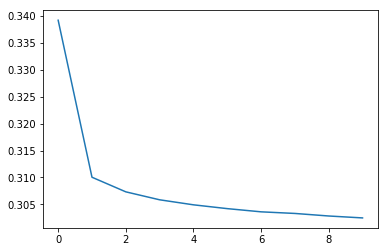

In [25]:
from matplotlib import pyplot as plt

plt.plot(model.history.history['loss'])
plt.show()